In [83]:
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
import seaborn as sns

In [85]:
data = pd.read_csv('data.csv')
del data['Unnamed: 0']

def split_time(x):
    hour = x['created_at'].hour
    if hour<6:
        return 0
    if hour<9:
        return 1
    if hour<12:
        return 2
    if hour<14:
        return 3
    if hour<18:
        return 4
    return 5
    
data['created_at'] = pd.to_datetime(data['created_at'])
#data['time'] = data.apply(lambda x:x['created_at'].hour*2+math.floor(x['created_at'].minute/30),axis=1)
data['time'] = data.apply(lambda x:split_time(x),axis=1)
data['total_num'] = data['like_num']+data['repost_num']+data['comment_num']
data['at_num'] = data.apply(lambda x:x['content'].count('@'),axis=1)
data['hash_num'] = data.apply(lambda x:x['content'].count('#'),axis=1)
data['has_video'] = data.apply(lambda x:0 if pd.isnull(x['video_url']) else 1,axis=1)
data['has_image'] = data.apply(lambda x:0 if pd.isnull(x['image_url']) else 1,axis=1)
data['is_origin'] = data.apply(lambda x:1 if pd.isnull(x['origin_weibo']) else 0,axis=1)
data['year'] = data.apply(lambda x:pd.to_datetime(x['created_at']).year,axis=1)

In [100]:
pd.set_option('display.max_columns', None)


In [122]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)   #降到2维
X = pd.get_dummies(data[['class','fans_num','day','time','tweets_num','at_num','hash_num','has_video','has_image','is_origin','year']],columns=['fans_num','tweets_num','year','class','day','time'])
pca.fit(X[1:])                  #训练
newX=pca.fit_transform(X[1:])   #降维后的数据
# PCA(copy=True, n_components=2, whiten=False)
print(pca.explained_variance_ratio_)  #输出贡献率
print(newX) 

[0.16548606 0.07548649 0.06672637 0.05506165 0.05374422 0.04640105
 0.04523893 0.04083997 0.03736861 0.03164682]
[[-0.62681942  0.18988595  1.02698066 ... -0.16141678 -0.1138646
   0.54102445]
 [-0.64922501  0.03474921 -0.3609393  ... -0.4764993   0.38756767
   0.60075153]
 [-0.62759763  0.06831173 -0.37057265 ...  0.81460257  0.14906345
   0.64632426]
 ...
 [-0.65414675  0.06253094 -0.40507421 ...  0.15268     0.39728888
   0.74729901]
 [-0.68378055 -0.27192497 -0.49276251 ... -0.38624501  0.31966709
   0.80223178]
 [-0.64336867 -0.01898967 -0.2961173  ...  0.20599884  0.69182577
   0.66338549]]


In [123]:
X

,at_num,hash_num,has_video,has_image,is_origin,fans_num_440832,fans_num_1701517,fans_num_2433088,fans_num_2768548,fans_num_3271509,fans_num_3391570,fans_num_4715643,fans_num_11854425,fans_num_12663548,fans_num_17623359,fans_num_45508632,fans_num_64313031,fans_num_65080428,fans_num_67096486,fans_num_88634880,tweets_num_18643,tweets_num_27546,tweets_num_29289,tweets_num_32467,tweets_num_35380,tweets_num_39458,tweets_num_42018,tweets_num_60773,tweets_num_61821,tweets_num_70848,tweets_num_93603,tweets_num_98971,tweets_num_107410,tweets_num_116185,tweets_num_152600,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,class_公共卫生事件,class_刑事案件,class_动物疫情,class_地质灾害,class_地震灾害,class_安全事故,class_恐怖袭击事件,class_森林草原火灾,class_气象灾害,class_洪涝灾害,class_海洋灾害,class_环境污染和生态破坏事件,class_生物灾害,class_网络与信息安全事件,class_群体性事件,class_金融突发事件,day_0,day_1,day_2,time_0,time_1,time_2,time_3,time_4,time_5
16,0,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
17,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
18,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
19,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
20,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
21,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
23,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
24,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
25,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0


In [91]:
data = data[~((data.year == 2010) | (data.year == 2011))]
one = data[data.total_num>=100]['total_num'].quantile(0.25)
two = data[data.total_num>=100]['total_num'].quantile(0.5)
three = data[data.total_num>=100]['total_num'].quantile(0.75)

def judge_level(x):
    if x['total_num']<=100:
        return 0
    return 1


data['total_class'] = data.apply(lambda x:judge_level(x),axis=1)
x = pd.get_dummies(data[['class','vip_level','fans_num','day','time','tweets_num','at_num','hash_num','has_video','has_image','is_origin','year']],columns=['year','class','day','time'])

y = data[['total_class']]

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(x_train, y_train)
predict_test = clf.predict(x_test)
print(accuracy_score(predict_test,y_test))

0.7921801954951126


/home/lyy/anaconda3/envs/science/lib/python3.6/site-packages/ipykernel_launcher.py:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [103]:
[i for i in range(10,1000,100)]

[10, 110, 210, 310, 410, 510, 610, 710, 810, 910]

In [5]:
X = np.array([[i,0] for i in data['comment_num']])
kmeans_comment = KMeans(n_clusters=4, random_state=0).fit_predict(X)#评论数聚类

X = np.array([[i,0] for i in data['repost_num']])
kmeans_repost = KMeans(n_clusters=4, random_state=0).fit_predict(X)#转发数聚类

X = np.array([[i,0] for i in data['like_num']])
kmeans_like = KMeans(n_clusters=100, random_state=0).fit_predict(X)#点赞数聚类

X = np.array([[i,0] for i in data['like_num']])+np.array([[i,0] for i in data['repost_num']])+np.array([[i,0] for i in data['comment_num']])
kmeans_total = KMeans(n_clusters=20, random_state=0).fit_predict(X)#三数之和聚类

#X = np.array([[i,0] for i in data['fans_num']])
#kmeans_fans = KMeans(n_clusters=20, random_state=0).fit_predict(X)#粉丝数分类

#X = np.array([[i,0] for i in data['tweets_num']])
#kmeans_tweets = KMeans(n_clusters=20, random_state=0).fit_predict(X)#微博数分类

#data['comment_class'] = kmeans_comment
#data['like_class'] = kmeans_like
#data['repost_class'] = kmeans_repost
#data['fans_class'] = kmeans_fans
#data['tweets_class']  = kmeans_tweets
#data['total_class'] = kmeans_total


In [105]:
data['total_class'] = data.apply(lambda x:0 if x['total_num']<1000 else 1,axis=1)
data.groupby(by='total_class').count()['id']

total_class
0    20859
1     2669
Name: id, dtype: int64

/home/lyy/anaconda3/envs/science/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/lyy/anaconda3/envs/science/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/lyy/anaconda3/envs/science/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()
/home/lyy/anaconda3/envs/science/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversio

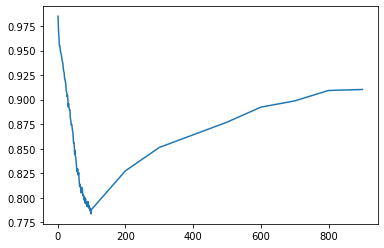

In [129]:
#temp = data[data.total_class>0]
result = np.empty(shape=[0,2])
for i in range(1,100):
    data['total_class'] = data.apply(lambda x:0 if x['total_num']<i else 1,axis=1)
    x = pd.get_dummies(data[['class','vip_level','fans_num','day','time','tweets_num','at_num','hash_num','has_video','has_image','is_origin','year']],columns=['year','class','day','time'])

    y = data[['total_class']]

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
    clf = RandomForestClassifier(n_estimators=10)
    clf = clf.fit(x_train, y_train)
    predict_test = clf.predict(x_test)
    #print(accuracy_score(predict_test,y_test))
    result = np.append(result,[[i,accuracy_score(predict_test,y_test)]],axis=0)
for i in range(100,1000,100):
    data['total_class'] = data.apply(lambda x:0 if x['total_num']<i else 1,axis=1)
    x = pd.get_dummies(data[['class','vip_level','fans_num','day','time','tweets_num','at_num','hash_num','has_video','has_image','is_origin','year']],columns=['year','class','day','time'])

    y = data[['total_class']]

    x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
    clf = RandomForestClassifier(n_estimators=10)
    clf = clf.fit(x_train, y_train)
    predict_test = clf.predict(x_test)
    #print(accuracy_score(predict_test,y_test))
    result = np.append(result,[[i,accuracy_score(predict_test,y_test)]],axis=0)

plt.plot(result[:,0],result[:,1])

In [130]:
2312/23000

0.10052173913043479

In [79]:
data.iloc[0]

id                                                              13
comment_num                                                      2
content          透过电影·感受灾难中人性的温暖。40元看《唐山大地震》，只要参与答题就有机会，每个通过获得特...
crawl_time                                              1557430208
created_at                                     2010-07-16 09:33:06
image_url                                                      NaN
like_num                                                         0
origin_weibo                                                   NaN
repost_num                                                       1
tool                                                  微博 weibo.com
user_id                                                 1645705403
video_url                                                      NaN
weibo_url                      https://weibo.com/1645705403/1RsRwB
class                                                         地震灾害
fans_num                                                   339

In [31]:
temp = pd.DataFrame(data.groupby(by='total_class').count()['id'])
temp['区间']=''
temp.loc[0,'区间'] = '(0,100)'
temp.loc[1,'区间'] = '(100,'+str(one)+')'
temp.loc[2,'区间'] = '('+str(one)+','+str(two)+')'
temp.loc[3,'区间'] = '('+str(two)+','+str(three)+')'
temp.loc[4,'区间'] = '('+str(three)+','+str(data.total_num.max())+')'
temp

,id,区间
total_class,,
0,11496,"(0,100)"
1,2972,"(100,166.0)"
2,3019,"(166.0,314.0)"
3,3019,"(314.0,850.0)"
4,3022,"(850.0,887841)"


In [684]:
def judge_level(x):
    if x['total_num']<=500:
        return 0
    if x['total_num']<=1000:
        return 1
    if x['total_num']<=1500:
        return 2
    if x['total_num']<=2000:
        return 3
    for i in range(2000,10001,2000):
        if x['total_num']<=i:
            return int(i/2000+2)
    for i in range(32500,100001,22500):
        if x['total_num']<=i:
            return int((i-10000)/22500)+7
    return 12

data['total_class'] = data.apply(lambda x:judge_level(x),axis=1)

In [685]:
def judge_level(x):
    if x['total_num']<=2000:
        return 0
    if x['total_num']<=8000:
        return 1
    if x['total_num']<=20000:
        return 2
    if x['total_num']<=100000:
        return 3
    return 4
data['total_class'] = data.apply(lambda x:judge_level(x),axis=1)





In [499]:

part = data[data.total_num<2000]
temp_part = part.groupby(by='total_class').describe()['total_num']

temp_part['max-min'] = temp_part['max']-temp_part['min']
temp_part['weight'] = temp_part['count']/data['total_num'].count()
temp_part

,count,mean,std,min,25%,50%,75%,max,max-min,weight
total_class,,,,,,,,,,
0,20052.0,110.338620,114.090945,0.0,25.00,70.0,155.0,500.0,500.0,0.819586
1,1746.0,704.638603,141.817533,501.0,577.00,684.0,816.0,1000.0,499.0,0.071364
2,737.0,1224.797829,142.490183,1001.0,1101.00,1213.0,1342.0,1500.0,499.0,0.030123
3,432.0,1750.752315,147.911309,1501.0,1622.75,1759.5,1881.5,1998.0,497.0,0.017657


In [506]:
x = pd.get_dummies(data[['class','vip_level','fans_num','day','time','tweets_num','at_num','hash_num','has_video','has_image','is_origin','year']],columns=['year','class','day','time'])

y = data[['total_class']]
#X = np.array([[i,0] for i in data['total_num']])
#y = KMeans(n_clusters=10, random_state=0).fit_predict(X)#点赞数聚类

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
clf = RandomForestClassifier(n_estimators=1000)
clf = clf.fit(x_train, y_train)

data_part = data[data.total_num<=2000]
x_p = pd.get_dummies(data_part[['class','vip_level','fans_num','day','time','tweets_num','at_num','hash_num','has_video','has_image','is_origin']],columns=['class','day','time'])

y_p = data_part[['total_class']]
x_train,x_test,y_train,y_test = train_test_split(x_p,y_p,test_size=0.3,random_state=0)
predict_test = clf.predict(x_test)
print(accuracy_score(predict_test,y_test))


data_part = data[data.total_num>2000]
x_p = pd.get_dummies(data,columns=['class','day','time'])
x_p = x_p[x_p.total_num>2000]
x_p = x_p[['vip_level','fans_num','tweets_num','at_num','hash_num','has_video','has_image','is_origin','class_公共卫生事件', 'class_刑事案件',
       'class_动物疫情', 'class_地质灾害', 'class_地震灾害', 'class_安全事故', 'class_恐怖袭击事件',
       'class_森林草原火灾', 'class_气象灾害', 'class_洪涝灾害', 'class_海洋灾害',
       'class_环境污染和生态破坏事件', 'class_生物灾害', 'class_网络与信息安全事件', 'class_群体性事件',
       'class_金融突发事件', 'day_0', 'day_1', 'day_2', 'time_0', 'time_1', 'time_2',
       'time_3', 'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9',
       'time_10', 'time_11', 'time_12', 'time_13', 'time_14', 'time_15',
       'time_16', 'time_17', 'time_18', 'time_19', 'time_20', 'time_21',
       'time_22', 'time_23', 'time_24', 'time_25', 'time_26', 'time_27',
       'time_28', 'time_29', 'time_30', 'time_31', 'time_32', 'time_33',
       'time_34', 'time_35', 'time_36', 'time_37', 'time_38', 'time_39',
       'time_40', 'time_41', 'time_42', 'time_43', 'time_44', 'time_45',
       'time_46', 'time_47']]
y_p = data_part[['total_class']]
x_train,x_test,y_train,y_test = train_test_split(x_p,y_p,test_size=0.3,random_state=0)

predict_test = clf.predict(x_test)
print(accuracy_score(predict_test,y_test))



/Users/zhongchengtao/anaconda3/envs/spark/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


0.9159773617762299
0.43333333333333335


In [596]:
num_map = {}
for i in range(5):
    t = data[data.total_class == i]
    cut = pd.cut(t['total_num'],100,labels=False)
    max_index = cut.value_counts().index[0]
    num = t.loc[cut[cut == max_index].index]['total_num'].mean()
    num_map[i] = {'num':num,'weight':int(data.count()['id']/t.count()['id'])}
    data.loc[data.total_class == i,'num'] = num

num_map

{0: {'num': 7.8988607300627764, 'weight': 1},
 1: {'num': 2391.815789473684, 'weight': 22},
 2: {'num': 10938.75, 'weight': 96},
 3: {'num': 20420.0, 'weight': 185},
 4: {'num': 112429.33333333333, 'weight': 1165}}

24466

In [822]:
data[data.year==2012].to_csv('2012.csv')

(array([64., 78., 73., 74., 64., 69., 57., 36., 49., 52., 49., 40., 39.,
        45., 32., 45., 55., 54., 64., 50., 55., 46., 60., 50., 53., 44.,
        44., 50., 52., 51., 59., 50., 43., 33., 47., 42., 34., 31., 32.,
        36., 34., 30., 38., 23., 33., 28., 22., 17., 33., 29., 25., 19.,
        17., 22., 21., 16., 27., 18., 20., 19., 13., 11., 14., 21., 20.,
        16., 19., 10., 19., 17., 13.,  9., 11., 11., 12., 18.,  9., 14.,
         8., 10.,  5., 10.,  6.,  9., 11.,  9., 10., 11.,  9.,  7.,  9.,
         7., 12.,  2.,  4.,  5.,  7.,  3.,  2.,  7.,  3., 11.,  7.,  7.,
         4., 10.,  7.,  4.,  4.,  6.,  1.,  5.,  4.,  5.,  8.,  6.,  3.,
         5.,  7.,  2.,  9.,  2.,  6.,  4.,  5.,  5.,  4.,  2.,  2.,  4.,
         2.,  0.,  6.,  7.,  4.,  6.,  0.,  3.,  8.,  5.,  5.,  5.,  2.,
         4.,  7.,  3.,  1.,  3.,  8.,  4.,  3.,  2.,  2.,  6.,  3.,  1.,
         3.,  3.,  4.,  2.,  4.,  3.,  4.,  3.,  2.,  3.,  3.,  3.,  1.,
         8.,  2.,  1.,  2.,  3.,  0.,  2.,  3.,  5.

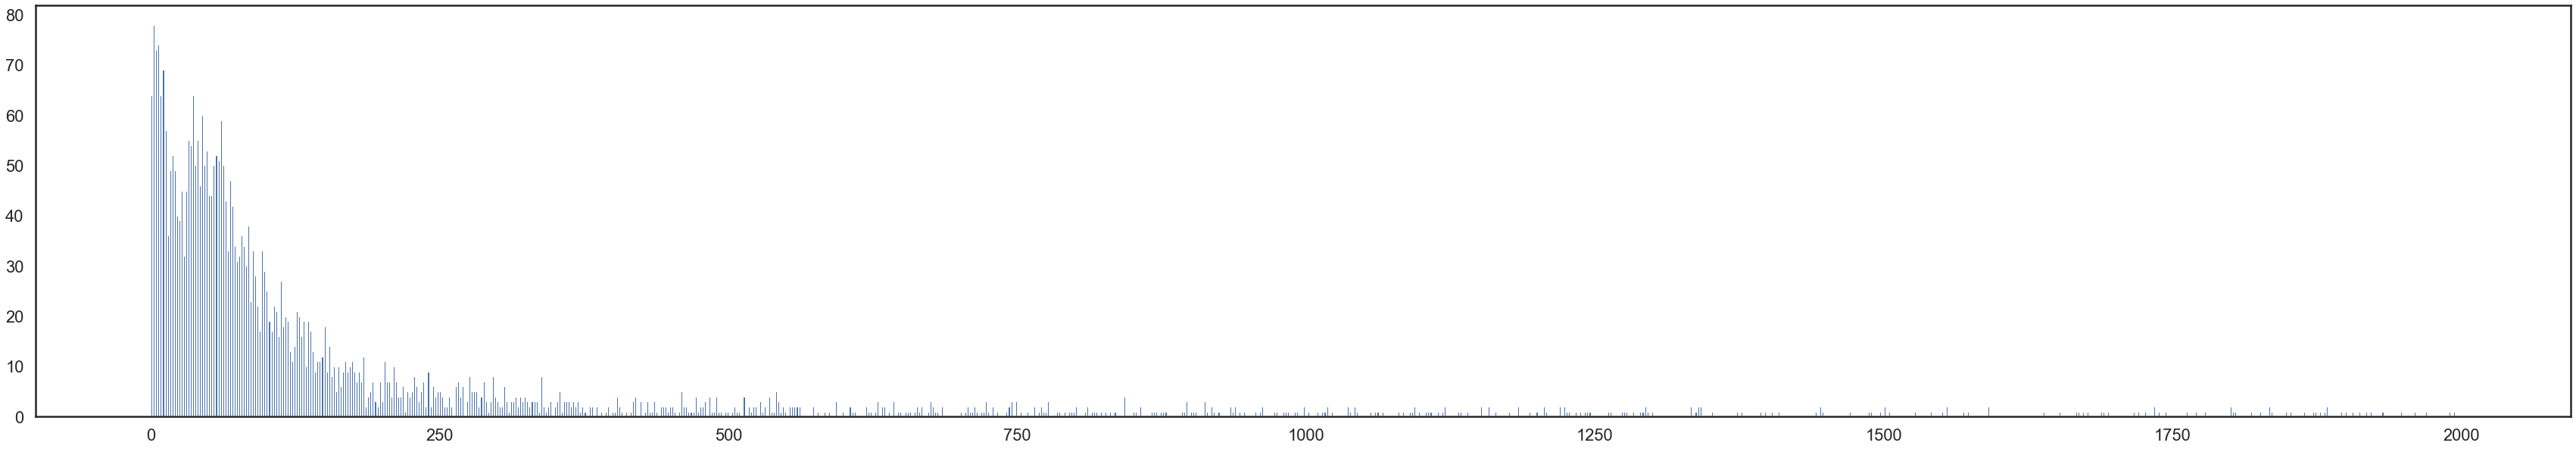

In [813]:
#pd.cut(data[data.total_class == 0]['total_num'],1000,labels=False).value_counts()
#pd.cut(data[data.total_class == 0]['total_num'],100,labels=False).plot(kind='hist')
for i in range(2010,2020,1):
    cut = pd.cut(data[(data.total_class == 0) & (data.year==i)]['total_num'],1000)
    
#type(cut)
#pd.DataFrame(cut.value_counts())
#pd.DataFrame(cut.cat.categories.tolist())
#cut.value_counts()
plt.figure(figsize=(60, 10))

#plt.hist(data[(data.total_class == 0) & (data.year==2014)]['total_num'],bins=1000)
#sns.kdeplot(data['total_num'])
#sns.distplot(data['total_num'])




In [742]:
x = pd.get_dummies(data[['class','vip_level','fans_num','day','time','tweets_num','at_num','hash_num','has_video','has_image','is_origin']],columns=['class','day','time'])

y = data[['total_class']]
#X = np.array([[i,0] for i in data['total_num']])
#y = KMeans(n_clusters=10, random_state=0).fit_predict(X)#点赞数聚类

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=0)
clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(x_train, y_train)
predict_test = clf.predict(x_test)
print(accuracy_score(predict_test,y_test))




/Users/zhongchengtao/anaconda3/envs/spark/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if __name__ == '__main__':


0.9326975476839237


In [673]:
x.columns

Index(['vip_level', 'fans_num', 'tweets_num', 'at_num', 'hash_num',
       'has_video', 'has_image', 'is_origin', 'class_公共卫生事件', 'class_刑事案件',
       'class_动物疫情', 'class_地质灾害', 'class_地震灾害', 'class_安全事故', 'class_恐怖袭击事件',
       'class_森林草原火灾', 'class_气象灾害', 'class_洪涝灾害', 'class_海洋灾害',
       'class_环境污染和生态破坏事件', 'class_生物灾害', 'class_网络与信息安全事件', 'class_群体性事件',
       'class_金融突发事件', 'day_0', 'day_1', 'day_2', 'time_0', 'time_1', 'time_2',
       'time_3', 'time_4', 'time_5', 'time_6', 'time_7', 'time_8', 'time_9',
       'time_10', 'time_11', 'time_12', 'time_13', 'time_14', 'time_15',
       'time_16', 'time_17', 'time_18', 'time_19', 'time_20', 'time_21',
       'time_22', 'time_23', 'time_24', 'time_25', 'time_26', 'time_27',
       'time_28', 'time_29', 'time_30', 'time_31', 'time_32', 'time_33',
       'time_34', 'time_35', 'time_36', 'time_37', 'time_38', 'time_39',
       'time_40', 'time_41', 'time_42', 'time_43', 'time_44', 'time_45',
       'time_46', 'time_47'],
      dtype

In [662]:
predict = pd.DataFrame(predict_test)
predict.columns = ['total_class']
test = y_test.reset_index()
result = test
del test['index']



In [663]:
result.iloc[(test-predict != 0)['total_class'],'res'] = 0
result.iloc[(test-predict == 0)['total_class'],'res'] = 1



NotImplementedError: iLocation based boolean indexing on an integer type is not available

In [671]:
temp = test-predict


total_class    7340
dtype: int64

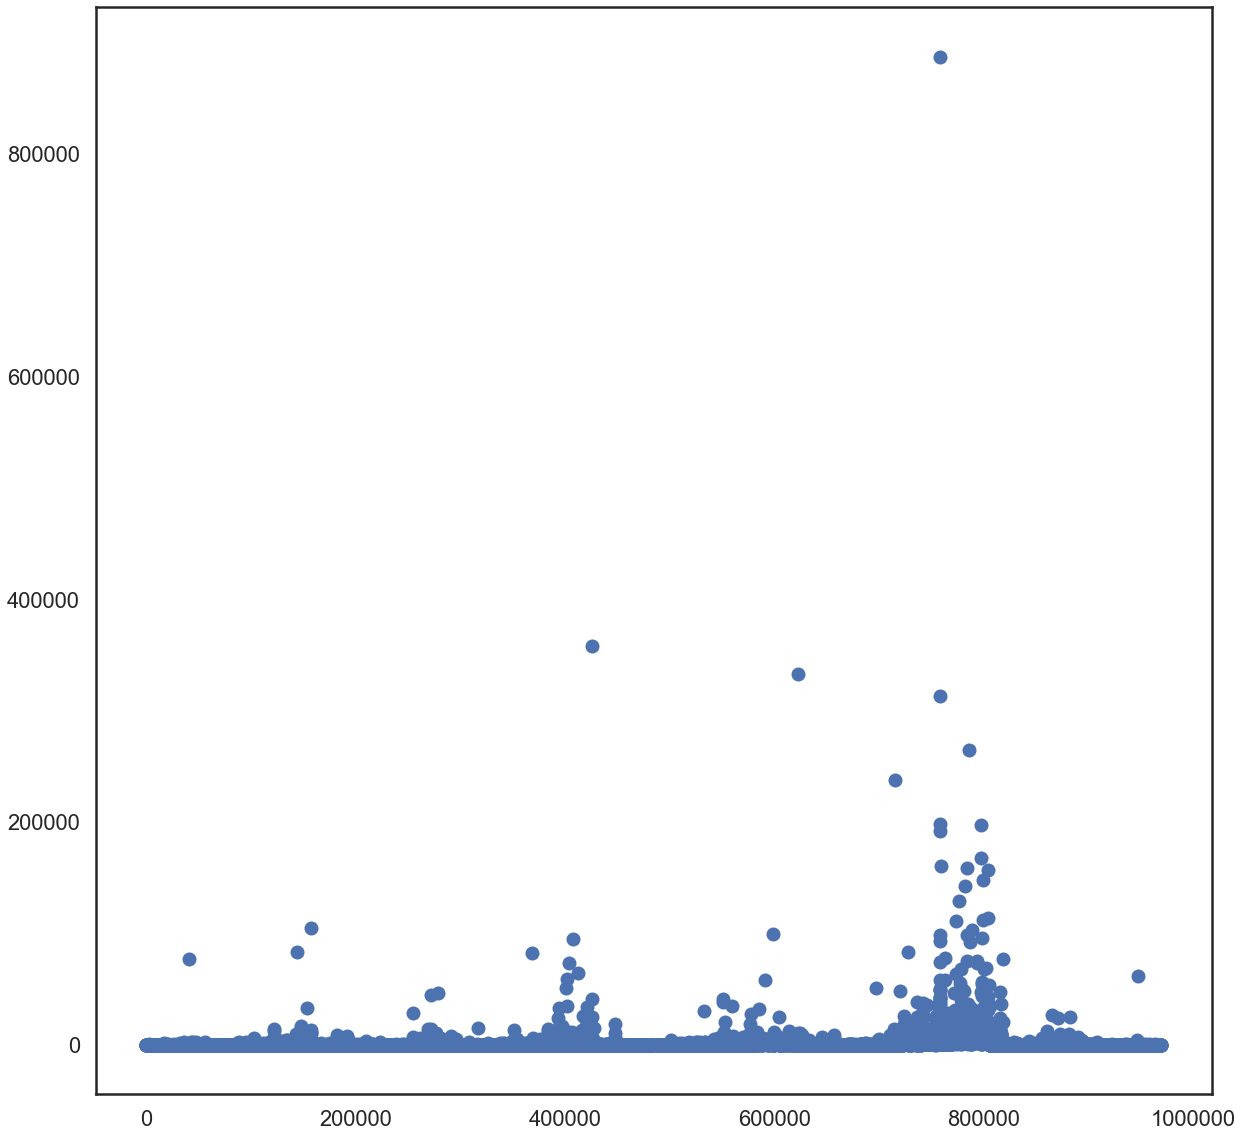

In [634]:
plt.figure(figsize=(20, 20))
plt.scatter(data['id'],data['total_num'])




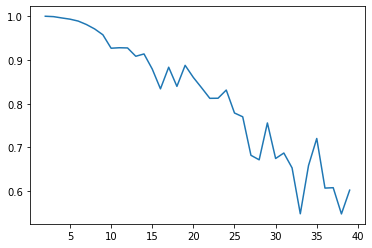

In [201]:
result = []
X = np.array([[i,0] for i in data['repost_num']])
kf = KFold(n_splits=10)

for i in range(2,40):
    kmeans_like = KMeans(n_clusters=i, random_state=0).fit_predict(X)
    acc = 0
    for train_index,test_index in kf.split(x):    
        x_train = x.iloc[train_index]
        y_train = kmeans_like[train_index]
        x_test = x.iloc[test_index]
        y_test = kmeans_like[test_index]
        #x_train,x_test,y_train,y_test = train_test_split(x,kmeans_like,test_size=0.3,random_state=0)
        clf = RandomForestClassifier(n_estimators=100)
        clf = clf.fit(x_train, y_train)
        predict_test = clf.predict(x_test)
        acc = acc + accuracy_score(predict_test,y_test)
    
    acc = acc/10
    

    #accuracy_score(predict_test,y_test)
    result.append([acc,i])
    
res = np.array(result)
plt.plot(res[:,1],res[:,0])

In [202]:
res

array([[ 0.99995912,  2.        ],
       [ 0.99905971,  3.        ],
       [ 0.99607531,  4.        ],
       [ 0.99329541,  5.        ],
       [ 0.98892112,  6.        ],
       [ 0.98103106,  7.        ],
       [ 0.97093347,  8.        ],
       [ 0.95756554,  9.        ],
       [ 0.92682418, 10.        ],
       [ 0.92792795, 11.        ],
       [ 0.92747829, 12.        ],
       [ 0.90842953, 13.        ],
       [ 0.9137434 , 14.        ],
       [ 0.8792859 , 15.        ],
       [ 0.83395679, 16.        ],
       [ 0.88337332, 17.        ],
       [ 0.83959687, 18.        ],
       [ 0.88766497, 19.        ],
       [ 0.85995203, 20.        ],
       [ 0.83640869, 21.        ],
       [ 0.81225192, 22.        ],
       [ 0.81245626, 23.        ],
       [ 0.83117681, 24.        ],
       [ 0.77873427, 25.        ],
       [ 0.77002845, 26.        ],
       [ 0.68198699, 27.        ],
       [ 0.67164588, 28.        ],
       [ 0.75592686, 29.        ],
       [ 0.67467039,

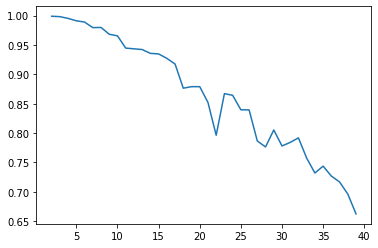

In [143]:
result = []
X = np.array([[i,0] for i in data['like_num']])
for i in range(2,40):
    kmeans_like = KMeans(n_clusters=i, random_state=0).fit_predict(X)
    x_train,x_test,y_train,y_test = train_test_split(x,kmeans_like,test_size=0.3,random_state=0)
    clf = RandomForestClassifier(n_estimators=100)
    clf = clf.fit(x_train, y_train)
    predict_test = clf.predict(x_test)
    #accuracy_score(predict_test,y_test)
    result.append([accuracy_score(predict_test,y_test),i])
    
res = np.array(result)
plt.plot(res[:,1],res[:,0])

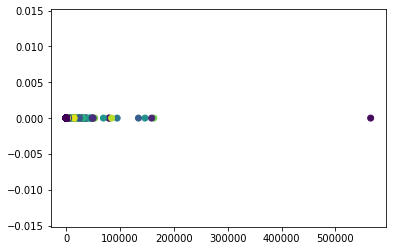

In [203]:
plt.scatter(X[:,0],X[:,1],c=kmeans_like)

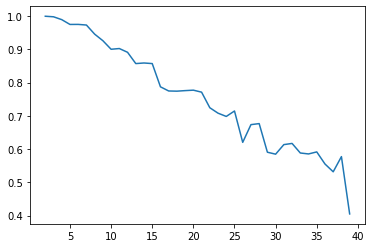

In [144]:
result = []
X = np.array([[i,0] for i in data['comment_num']])
for i in range(2,40):
    kmeans_like = KMeans(n_clusters=i, random_state=0).fit_predict(X)
    x_train,x_test,y_train,y_test = train_test_split(x,kmeans_like,test_size=0.3,random_state=0)
    clf = RandomForestClassifier(n_estimators=100)
    clf = clf.fit(x_train, y_train)
    predict_test = clf.predict(x_test)
    #accuracy_score(predict_test,y_test)
    result.append([accuracy_score(predict_test,y_test),i])
    
res = np.array(result)
plt.plot(res[:,1],res[:,0])